<a href="https://colab.research.google.com/github/Shiyi-Xia/NLP_ESS_2022/blob/main/Tutorial_Six_(R)_Incorporating_Pretrained_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Incorporating Pretrained Embeddings

## Douglas Rice


*This tutorial was originally created by Burt Monroe for his prior work with the Essex Summer School. I've updated and modified it.*

In this notebook, we'll update our classifier to go beyond the one-hot representation of text to incorprate pre-trained embeddings as features. After completing this notebook, you should be familar with:


1. Yadda
2. Yadda



#### Setup Instructions:
This notebook was designed to run in a clean R runtime within Google Colab. Before running any of the code below, go up to the menu at the top of the window and click "runtime," then, from the dropdown, click "Disconnect and Delete Runtime". Then, reconnect. That should get everything set up to run smoothly.


## Setup

In [ ]:
install.packages("keras") # install R library for keras; this installs dependencies we'll need, including tensorflow

library(tensorflow) # load R library for tensorflow
library(keras) # load R library for keras

tf$constant("Hello Tensorflow") # check that tensorflow is working

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘RcppTOML’, ‘here’, ‘png’, ‘config’, ‘tfautograph’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’


Loaded Tensorflow version 2.8.2



tf.Tensor(b'Hello Tensorflow', shape=(), dtype=string)

We now need to add a new package, `tfhub`. This is the Tensorflow Hub, which is a repository of reusable machine learning models. `tfhub` is an R package that provides access to all of the models retained on Tensorflow Hub. 

In [ ]:
install.packages("tfhub")
library(tfhub)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



## Load the IMDB data


In [ ]:
if (dir.exists("aclImdb/"))
  unlink("aclImdb/", recursive = TRUE)
url <- "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset <- get_file(
  "aclImdb_v1",
  url,
  untar = TRUE,
  cache_dir = '.',
  cache_subdir = ''
)
unlink("aclImdb/train/unsup/", recursive = TRUE)

In [ ]:
batch_size <- 512
seed <- 42

train_data <- text_dataset_from_directory(
  'aclImdb/train',
  batch_size = batch_size,
  validation_split = 0.2,
  subset = 'training',
  seed = seed
)
validation_data <- text_dataset_from_directory(
  'aclImdb/train',
  batch_size = batch_size,
  validation_split = 0.2,
  subset = 'validation',
  seed = seed
)
test_data <- text_dataset_from_directory(
  'aclImdb/test',
  batch_size = batch_size
)

In [ ]:
batch <- train_data %>%
  reticulate::as_iterator() %>%
  reticulate::iter_next()

batch[[1]][1]

tf.Tensor(b'Upon seeing this film once again it appeared infinitely superior to me this time than the previous times I have viewed it. The acting is stunningly wonderful. The characters are very clearly drawn. Brad Pitt is simply superb as the errant son who rebels. The other actors and actresses are equally fine in every respect. Robert Redford creates a wonderful period piece from the days of speakeasies of the 1920s. The scenery is incredibly beautiful of the mountains and streams of western Montana. All in all, this is one of the finest films made in the 1990s.<br /><br />You must see this movie!<br /><br />', shape=(), dtype=string)

## Employing Pretrained Embeddings: Frozen

We start by using the pre-trained embeddings "as-is". That is, the distribution of weights will be "frozen" as is for each of the words. 

The first step, then, is to identify the pre-trained embeddings we would like to employ as our feature set. We will use the 50-dimensional "Token based text embedding trained on English Google News 7B corpus" available from TensorflowHub at "https://tfhub.dev/google/nnlm-en-dim50/2". (It is worth noting that they do not specify, and I do not know, several important things about these embeddings: (1) what year(s) of data were they trained on, (2) what method (word2vec, GloVe, etc.), (3) what parameters, esp. context window size.

We need to indicate, of course, where Python should look to find the pre-trained embeddings on TensorflowHub. We specify that in the first line below.

Then we'll add a "hub" "Keras Layer" at the front of our model. This takes each training example (think of it as multi-hot vector of ones and zeros, the length of the vocabulary, V) and multiply it by the embedding matrix, V x 50, producing a 1x50 input equivalent to the *average of the embeddings for the individual words in a document*.

To get an idea of what this does, we'll look at the first three documents after they've been run through this layer.

In [ ]:
embedding <- "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer <- layer_hub(handle = embedding, input_shape = c(), trainable = FALSE)

In [ ]:
hub_layer(batch[[1]][1:3])

tf.Tensor(
[[ 0.2563908   0.3877134   0.11458009  0.46377143 -0.27114576 -0.23548658
  -0.05462555  0.05912564 -0.5467191   0.31118706 -0.16002828 -0.0705342
  -0.2470538   0.09001822 -0.04209791 -0.33874798 -0.24183154 -0.32309988
   0.10837323 -0.63822275  0.07474954 -0.47535443  0.40693292  0.31290898
  -0.15077832  0.16694833 -0.6367394   0.18927394  0.4457423  -0.24568915
  -0.46415132  0.2513454   0.14228597 -0.44085875 -0.2652811   0.0990484
   0.18815233 -0.05307329  0.26779363 -0.6057923  -0.27559572  0.05044953
  -0.48596263  0.21479745 -0.1746156  -0.6422215  -0.3165063  -0.33656728
  -0.09484117 -0.07192937]
 [ 1.2899797   0.32863247 -0.00310844  0.82322246 -0.4098285  -0.5109544
   0.08370163 -0.13269287 -1.170054    0.5531664  -0.05031176  0.14853315
  -0.15995876  0.26997143 -0.34048218 -0.4932976  -0.25939593  0.03390278
   0.25013083 -1.4177161   0.19143653 -0.23920083  1.2250862   0.41607666
  -0.6656541   0.4240742  -1.280362    0.4722922   0.5342671  -0.84027433
  -

In [ ]:
model <- keras_model_sequential() %>%
  hub_layer() %>%
  layer_dense(units = 16, activation = "relu") %>%
  layer_dense(units = 1)

summary(model)

Model: <no summary available, model was not built>


In [ ]:
model %>% compile(
  optimizer = 'adam',
  loss = 'binary_crossentropy',
  metrics = c('accuracy')
)

In [ ]:
history <- model %>% fit(
  train_data,
  epochs = 20,
  validation_data = validation_data,
  verbose <- 1
)

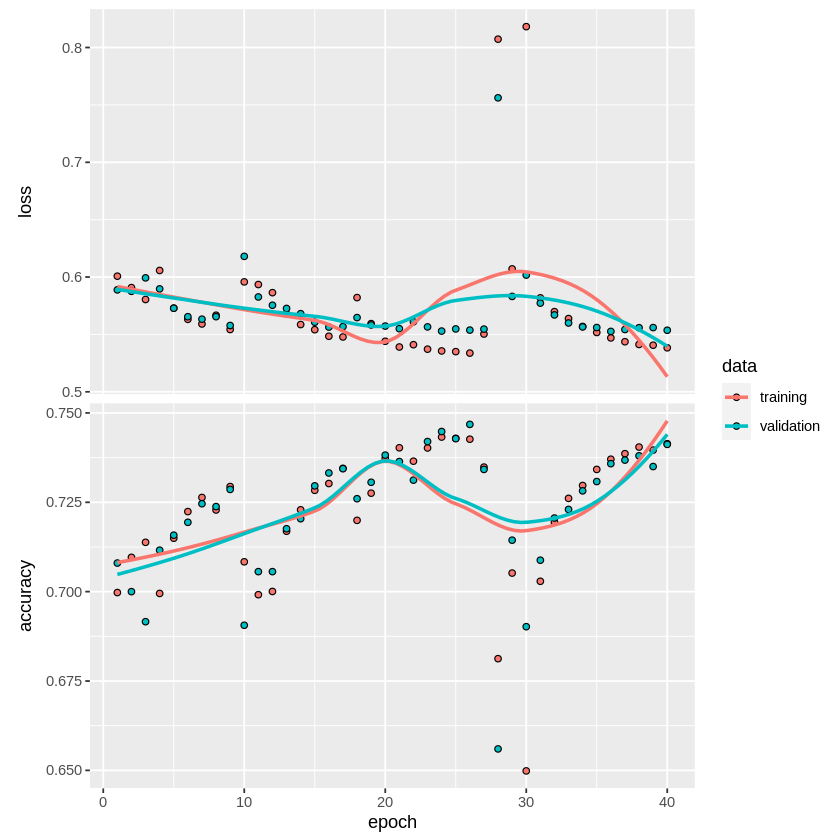

In [ ]:
plot(history)

In [ ]:
results <- model %>% evaluate(test_data, verbose = 2)

In [ ]:
results

loss  accuracy 
0.5549017 0.7312800

Yikes. That's not good. The embeddings were *supposed* to help us build a better feature set, but we're doing substantially worse. Why? The plots suggest maybe we could gain a bit of leverage by letting this run longer. But more likely is that the embeddings just aren't give us any more information than we already had. What if we could update those embeddings?

## Fine-tuning the embeddings

Let's try that out. We'll do everything the same, but we'll let the embedding layer be trainable. Programming-wise, this is exceptionally easy.

In [ ]:
embedding <- "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer <- layer_hub(handle = embedding, input_shape = c(), trainable = TRUE)

But under the hood, things just got a lot more complicated. We now 48 million trainable parameters; that's scarier than it seems though. Many of those apply to tokens that appear in the embeddings but not in the IMDB corpus. Still, we can reasonably expect estimation is going to take longer now.

In [ ]:
model <- keras_model_sequential() %>%
  hub_layer() %>%
  layer_dense(units = 16, activation = "relu") %>%
  layer_dense(units = 1)

summary(model)

Model: <no summary available, model was not built>


In [ ]:
model %>% compile(
  optimizer = 'adam',
  loss = 'binary_crossentropy',
  metrics = c('accuracy')
)

In [ ]:
history <- model %>% fit(
  train_data,
  epochs = 20,
  validation_data = validation_data,
  verbose <- 1
)

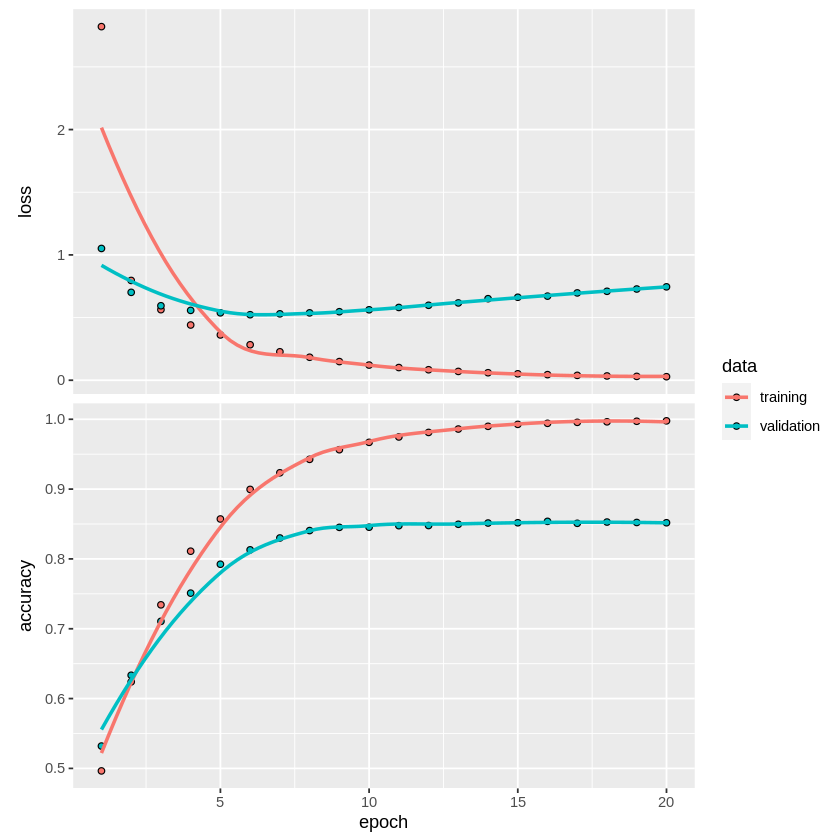

In [ ]:
plot(history)

In [ ]:
results <- model %>% evaluate(test_data, verbose = 2)

In [ ]:
results

loss  accuracy 
0.9082595 0.8242000

That's slightly better. Let's try out some other tweaks.

## 128-dimensional embeddings

Let's try the same, but with a richer 128-dimensional set of embeddings.

This will give us 124 million trainable parameters!

In [ ]:
embedding <- "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer <- layer_hub(handle = embedding, input_shape = c(), trainable = TRUE)

In [ ]:
model <- keras_model_sequential() %>%
  hub_layer() %>%
  layer_dense(units = 16, activation = "relu") %>%
  layer_dense(units = 1)

summary(model)

Model: <no summary available, model was not built>


In [ ]:
model %>% compile(
  optimizer = 'adam',
  loss = 'binary_crossentropy',
  metrics = c('accuracy')
)

In [ ]:
history <- model %>% fit(
  train_data,
  epochs = 20,
  validation_data = validation_data,
  verbose <- 1
)

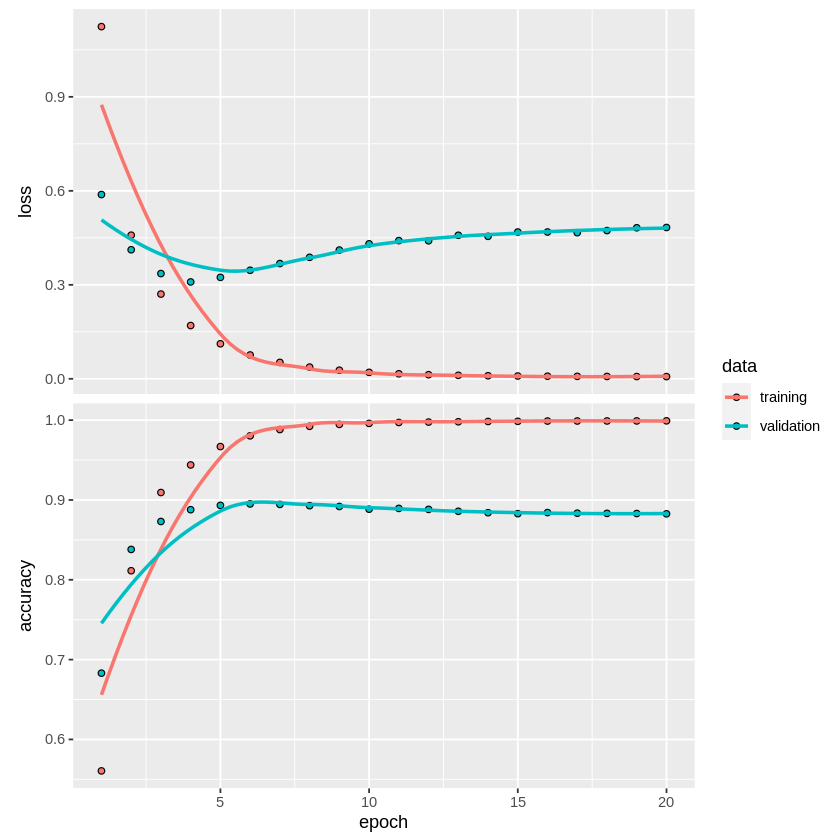

In [ ]:
plot(history)

In [ ]:
results <- model %>% evaluate(test_data, verbose = 2)

In [ ]:
results

loss  accuracy 
0.6438386 0.8583200

About 86%. That said, the validation data in the above plot looks like it was up around 89% or even a little higher, which suggests we may be able to improve. Let's try again with earlier stopping.

In [ ]:
model <- keras_model_sequential() %>%
  hub_layer() %>%
  layer_dense(units = 16, activation = "relu") %>%
  layer_dense(units = 1)

summary(model)

Model: <no summary available, model was not built>


In [ ]:
model %>% compile(
  optimizer = 'adam',
  loss = 'binary_crossentropy',
  metrics = c('accuracy')
)

In [ ]:
history <- model %>% fit(
  train_data,
  epochs = 5,
  validation_data = validation_data,
  verbose <- 1
)

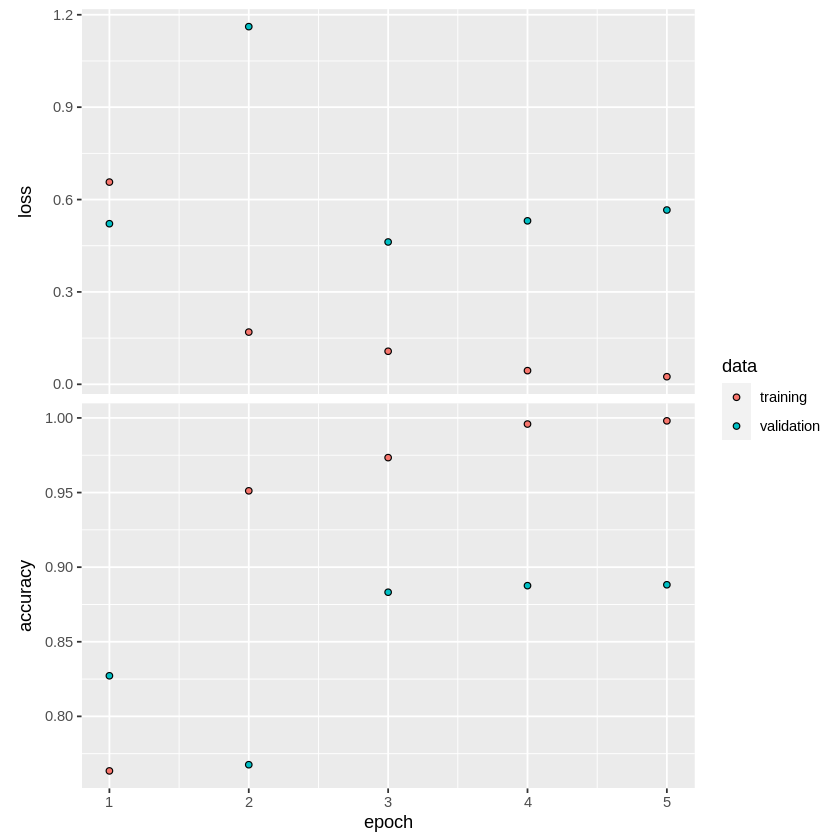

In [ ]:
plot(history)

In [ ]:
results <- model %>% evaluate(test_data, verbose = 2)

In [ ]:
results

loss  accuracy 
0.7222266 0.8624000

86.2% now. A tiny bit better than we'd been doing, but not quite the level of improvement we were hoping for. 